In [258]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime
import holidays

from matplotlib import pyplot as plt

In [259]:
path = 'June2019'

In [260]:
def create_trip_DF(path):
  df = pd.read_csv(path)
  df.drop(['extra', 'RatecodeID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count', 'store_and_fwd_flag', 'tolls_amount', 'VendorID', 'tip_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'mta_tax'], axis=1, inplace=True)
  df.rename(columns={'tpep_pickup_datetime':'pickup_datetime', 'tpep_dropoff_datetime':'dropoff_datetime', 'PULocationID': 'pickup_location_ID', 'DOLocationID':'dropoff_location_ID'}, inplace=True)
  df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df.dropna()
  df = df[(df['fare_amount'] >= 2.50) & (df['trip_distance'] > 0)]
  return df

In [261]:
trip_DF = create_trip_DF('./raw_taxi_data/' + path + '.csv')
print(len(trip_DF.index))

6864689


In [262]:
trip_DF.describe()

,trip_distance,pickup_location_ID,dropoff_location_ID,fare_amount
count,6.864689e+06,6.864689e+06,6.864689e+06,6.864689e+06
mean,3.101730e+00,1.623054e+02,1.605868e+02,1.353621e+01
std,3.993169e+00,6.631148e+01,7.035755e+01,1.252278e+01
min,1.000000e-02,1.000000e+00,1.000000e+00,2.500000e+00
25%,1.000000e+00,1.140000e+02,1.070000e+02,6.500000e+00
50%,1.700000e+00,1.610000e+02,1.620000e+02,9.500000e+00
75%,3.180000e+00,2.330000e+02,2.330000e+02,1.500000e+01
max,2.295700e+02,2.650000e+02,2.650000e+02,9.022000e+03


In [263]:
time_of_day_bins = ['PU_time_2AM-5:59AM', 'PU_time_6AM-9:59AM',
               'PU_time_10AM-1:59PM', 'PU_time_2PM-5:59PM',
               'PU_time_6PM-9:59PM', 'PU_time_10PM-1:59AM']

def get_time_of_day_bin(timestamp, time_of_day_bins):
  if 2 <= timestamp.hour and timestamp.hour < 6:
    return time_of_day_bins[0]
  elif 6 <= timestamp.hour and timestamp.hour < 10:
    return time_of_day_bins[1]
  elif 10 <= timestamp.hour and timestamp.hour < 14:
    return time_of_day_bins[2]
  elif 14 <= timestamp.hour and timestamp.hour < 18:
    return time_of_day_bins[3]
  elif 18 <= timestamp.hour and timestamp.hour < 22:
    return time_of_day_bins[4]
  else:
    return time_of_day_bins[5]

In [264]:
def append_and_fill_time_of_day_bins(df, time_of_day_bins):
  for time_bin in time_of_day_bins:
    print(time_bin)
    df[time_bin] = df['pickup_datetime'].map(lambda timestamp: 1 if get_time_of_day_bin(timestamp, time_of_day_bins) == time_bin else 0)

In [265]:
append_and_fill_time_of_day_bins(trip_DF, time_of_day_bins)

PU_time_2AM-5:59AM
PU_time_6AM-9:59AM
PU_time_10AM-1:59PM
PU_time_2PM-5:59PM
PU_time_6PM-9:59PM
PU_time_10PM-1:59AM


In [266]:
weekend_days = [5, 6]
us_holidays = holidays.US()
def is_weekend_or_holiday(date):
  date_day = date.day
  stringified_date = str(date)
  if date_day in weekend_days:
    return True
  elif stringified_date in us_holidays:
    return True
  else:
    return False

In [267]:
trip_DF['pickup_date'] = trip_DF['pickup_datetime'].map(lambda timestamp: timestamp.date())

In [268]:
def create_avg_fare_df(df):
  fare_prediction_df = df.groupby(["pickup_location_ID", "dropoff_location_ID", "pickup_date"] + time_of_day_bins, as_index=False).agg(avg_fare=('fare_amount', 'mean'))
  return fare_prediction_df

In [269]:
trip_avg_fare_DF = create_avg_fare_df(trip_DF)

In [270]:
# if trips occur on weekend or US holiday
trip_avg_fare_DF['weekend/holiday'] = trip_avg_fare_DF['pickup_date'].map(lambda date: 1 if is_weekend_or_holiday(date) else 0)

In [271]:
## Enforce that pickup and dropoff IDs are ints
trip_avg_fare_DF = trip_avg_fare_DF.astype({"pickup_location_ID": int, "dropoff_location_ID": int})

In [272]:
trip_avg_fare_DF.head(10)

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday
0,1,1,2019-06-02,0,0,0,0,1,0,127.00,0
1,1,1,2019-06-02,0,0,0,1,0,0,109.50,0
2,1,1,2019-06-02,0,1,0,0,0,0,20.00,0
3,1,1,2019-06-03,0,0,0,0,1,0,47.00,0
4,1,1,2019-06-03,0,0,1,0,0,0,89.25,0
5,1,1,2019-06-03,0,1,0,0,0,0,100.00,0
6,1,1,2019-06-04,0,0,0,0,1,0,94.85,0
7,1,1,2019-06-05,0,0,0,0,1,0,96.00,1
8,1,1,2019-06-05,0,0,0,1,0,0,116.00,1
9,1,1,2019-06-05,0,0,1,0,0,0,69.50,1


In [273]:
len(trip_avg_fare_DF.index)

842173

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b5723850>]],
      dtype=object)

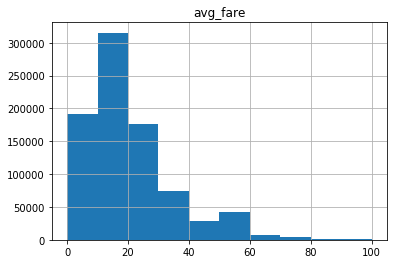

In [274]:
trip_avg_fare_DF.hist(column="avg_fare", bins=10, range=(0, 100))

In [275]:
## Need to drop the following columns when doing training & testing
## 1. pickup_location_ID
## 2. dropoff_location_ID
## 3. pickup_date
## 4. avg_fare as this is the target

In [276]:
## Construct 1-hot vectors for pickup and dropoff locations
## There are 265 unique location IDs
location_IDs = [i for i in range(1, 266)]

In [277]:
trip_avg_fare_DF['pickup_location_ID'] = trip_avg_fare_DF['pickup_location_ID'].astype(CategoricalDtype(location_IDs))
trip_avg_fare_DF['dropoff_location_ID'] = trip_avg_fare_DF['dropoff_location_ID'].astype(CategoricalDtype(location_IDs))
trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['pickup_location_ID'], prefix='PU_ID')], axis=1)
trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['dropoff_location_ID'], prefix='DO_ID')], axis=1)

In [278]:
trip_avg_fare_DF.head(10)

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,...,DO_ID_256,DO_ID_257,DO_ID_258,DO_ID_259,DO_ID_260,DO_ID_261,DO_ID_262,DO_ID_263,DO_ID_264,DO_ID_265
0,1,1,2019-06-02,0,0,0,0,1,0,127.00,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2019-06-02,0,0,0,1,0,0,109.50,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2019-06-02,0,1,0,0,0,0,20.00,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2019-06-03,0,0,0,0,1,0,47.00,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2019-06-03,0,0,1,0,0,0,89.25,...,0,0,0,0,0,0,0,0,0,0
5,1,1,2019-06-03,0,1,0,0,0,0,100.00,...,0,0,0,0,0,0,0,0,0,0
6,1,1,2019-06-04,0,0,0,0,1,0,94.85,...,0,0,0,0,0,0,0,0,0,0
7,1,1,2019-06-05,0,0,0,0,1,0,96.00,...,0,0,0,0,0,0,0,0,0,0
8,1,1,2019-06-05,0,0,0,1,0,0,116.00,...,0,0,0,0,0,0,0,0,0,0
9,1,1,2019-06-05,0,0,1,0,0,0,69.50,...,0,0,0,0,0,0,0,0,0,0


In [279]:
agg_fare_path = path + '_avg_fare'
trip_avg_fare_DF = trip_avg_fare_DF.sample(frac=0.25)
trip_avg_fare_DF.to_csv('./agg_taxi_fare_data/' + agg_fare_path + '.csv') 

In [280]:
trip_avg_fare_DF.shape

(210543, 541)